### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# HiFi GAN

*Author: NVIDIA*

**The HiFi GAN model for generating waveforms from mel spectrograms**

<img src="https://pytorch.org/assets/images/hifigan_model.png" alt="alt" width="50%"/>



### Model Description
This notebook demonstrates a PyTorch implementation of the HiFi-GAN model described in the paper: [HiFi-GAN: Generative Adversarial Networks for Efficient and High Fidelity Speech Synthesis](https://arxiv.org/abs/2010.05646).
The HiFi-GAN model implements a spectrogram inversion model that allows to synthesize speech waveforms from mel-spectrograms. It follows the generative adversarial network (GAN) paradigm, and is composed of a generator and a discriminator. After training, the generator is used for synthesis, and the discriminator is discarded.

Our implementation is based on the one [published by the authors of the paper](https://github.com/jik876/hifi-gan). We modify the original hyperparameters and provide an alternative training recipe, which enables training on larger batches and faster convergence. HiFi-GAN is trained on a publicly available [LJ Speech dataset](https://keithito.com/LJ-Speech-Dataset/). The <a href="audio/">samples</a> demonstrate speech synthesized with our publicly available FastPitch and HiFi-GAN checkpoints.

#### Model architecture

![HiFiGAN Architecture](https://raw.githubusercontent.com/NVIDIA/DeepLearningExamples/master/PyTorch/SpeechSynthesis/HiFiGAN/img/hifigan_model.png)

### Example
In the example below:

- pretrained FastPitch and HiFiGAN models are loaded from torch.hub
- given tensor representation of an input text ("Say this smoothly to prove you are not a robot."), FastPitch generates mel spectrogram
- HiFiGAN generates sound given the mel spectrogram
- the output sound is saved in an 'audio.wav' file

To run the example you need some extra python packages installed. These are needed for preprocessing of text and audio, as well as for display and input/output handling. Finally, for better performance of FastPitch model, we download the CMU pronounciation dictionary.

In [1]:
%%bash
pip install numpy scipy librosa unidecode inflect librosa matplotlib==3.6.3
apt-get update
apt-get install -y libsndfile1 wget
wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/heteronyms-052722 -qO heteronyms
wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 -qO cmudict-0.7b

Couldn't find program: 'bash'


In [2]:
# 安装 Python 包
!pip install numpy scipy librosa unidecode inflect matplotlib==3.6.3

# 下载两个文件
import urllib.request

# heteronyms
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/heteronyms-052722",
    "heteronyms"
)

# cmudict
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/cmudict-0.7b_nv22.08",
    "cmudict-0.7b"
)


('cmudict-0.7b', <http.client.HTTPMessage at 0x14e67fd5d00>)

In [3]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


Download and setup FastPitch generator model.

In [4]:
fastpitch, generator_train_setup = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_fastpitch')

Using cache found in C:\Users\wuann/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


Download and setup vocoder and denoiser models.

In [5]:
hifigan, vocoder_train_setup, denoiser = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_hifigan')

Using cache found in C:\Users\wuann/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


HiFi-GAN: Removing weight norm.


Verify that generator and vocoder models agree on input parameters.

In [6]:
CHECKPOINT_SPECIFIC_ARGS = [
    'sampling_rate', 'hop_length', 'win_length', 'p_arpabet', 'text_cleaners',
    'symbol_set', 'max_wav_value', 'prepend_space_to_text',
    'append_space_to_text']

for k in CHECKPOINT_SPECIFIC_ARGS:

    v1 = generator_train_setup.get(k, None)
    v2 = vocoder_train_setup.get(k, None)

    assert v1 is None or v2 is None or v1 == v2, \
        f'{k} mismatch in spectrogram generator and vocoder'

Put all models on available device.

In [7]:
fastpitch.to(device)
hifigan.to(device)
denoiser.to(device)

Denoiser(
  (stft): STFT()
)

Load text processor.

In [8]:
tp = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_textprocessing_utils', cmudict_path="cmudict-0.7b", heteronyms_path="heteronyms")

Using cache found in C:\Users\wuann/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


Set the text to be synthetized, prepare input and set additional generation parameters.

In [14]:
text = "The examination and testimony of the experts enabled the Commission to conclude that five shots may have been fired"

In [15]:
batches = tp.prepare_input_sequence([text], batch_size=1)

the {IH0 G Z AE2 M AH0 N EY1 SH AH0 N} and {T EH1 S T IH0 M OW2 N IY0} of the {EH1 K S P ER0 T S} enabled the {K AH0 M IH1 SH AH0 N} to {K AH0 N K L UW1 D} that {F AY1 V} {SH AA1 T S} {M EY1} {HH AE1 V} been {F AY1 ER0 D}


In [16]:
gen_kw = {'pace': 1.0,
          'speaker': 0,
          'pitch_tgt': None,
          'pitch_transform': None}
denoising_strength = 0.005

In [17]:
for batch in batches:
    with torch.no_grad():
        mel, mel_lens, *_ = fastpitch(batch['text'].to(device), **gen_kw)
        audios = hifigan(mel).float()
        audios = denoiser(audios.squeeze(1), denoising_strength)
        audios = audios.squeeze(1) * vocoder_train_setup['max_wav_value']


Plot the intermediate spectorgram.

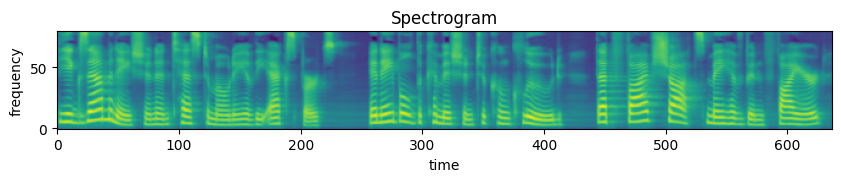

In [18]:
plt.figure(figsize=(10,12))
res_mel = mel[0].detach().cpu().numpy()
plt.imshow(res_mel, origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')
_=plt.title('Spectrogram')

Syntesize audio.

In [19]:
audio_numpy = audios[0].cpu().numpy()
Audio(audio_numpy, rate=22050)

In [20]:
audio_numpy.shape

(163072,)

Write audio to wav file.

In [21]:
from scipy.io.wavfile import write
write("audio.wav", vocoder_train_setup['sampling_rate'], audio_numpy)

### Details
For detailed information on model input and output, training recipies, inference and performance visit: [github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/HiFiGAN) and/or [NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/hifigan_pyt)

### References

 - [HiFi-GAN: Generative Adversarial Networks for Efficient and High Fidelity Speech Synthesis](https://arxiv.org/abs/2010.05646)
 - [Original implementation](https://github.com/jik876/hifi-gan)
 - [FastPitch on NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/fastpitch_pyt)
 - [HiFi-GAN on NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/hifigan_pyt)
 - [FastPitch and HiFi-GAN on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/HiFi-GAN)

# Getting started with AudioSeal

This notebook shows a minimal example to get started with AudioSeal. Make sure you install the package from PyPi or from source in editable mode beforehand.

First, let's prepare some example audios into the proper Tensor format using Torchaudio

In [22]:
%%capture

# For the demonstration, we need torchaudio and matplotlib to process example audios and visualize the spectrogram
import sys
!{sys.executable} -m pip install torchaudio soundfile matplotlib

In [23]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())

    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()
print(audio.shape, sr)

torch.Size([1, 167226]) 22050


In [24]:
print(audio.squeeze()[1:100])

tensor([-4.2725e-04, -1.8311e-04, -6.1035e-05, -2.7466e-04, -1.2207e-04,
        -2.1362e-04, -2.7466e-04, -3.0518e-05,  6.1035e-05,  2.1362e-04,
         2.4414e-04,  9.1553e-05,  1.2207e-04,  3.9673e-04,  5.1880e-04,
         4.5776e-04,  4.2725e-04,  3.3569e-04,  1.2207e-04,  0.0000e+00,
         0.0000e+00, -3.0518e-04, -3.9673e-04, -3.3569e-04, -6.1035e-04,
        -5.1880e-04, -4.2725e-04, -3.9673e-04, -4.8828e-04, -3.9673e-04,
        -2.4414e-04, -1.8311e-04, -2.4414e-04, -9.1553e-05, -1.2207e-04,
        -6.1035e-05,  1.8311e-04,  3.3569e-04,  3.9673e-04,  3.0518e-04,
         4.2725e-04,  2.7466e-04,  4.2725e-04,  1.8311e-04,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  6.1035e-05,  1.5259e-04,
         1.2207e-04,  9.1553e-05, -1.5259e-04, -2.1362e-04, -1.8311e-04,
        -2.7466e-04, -2.1362e-04, -3.0518e-04, -5.1880e-04, -4.2725e-04,
        -4.5776e-04, -4.2725e-04, -4.2725e-04, -2.1362e-04, -2.4414e-04,
        -6.1035e-05,  1.5259e-04,  2.1362e-04,  2.7

(Quick check of the original content and spectrogram)

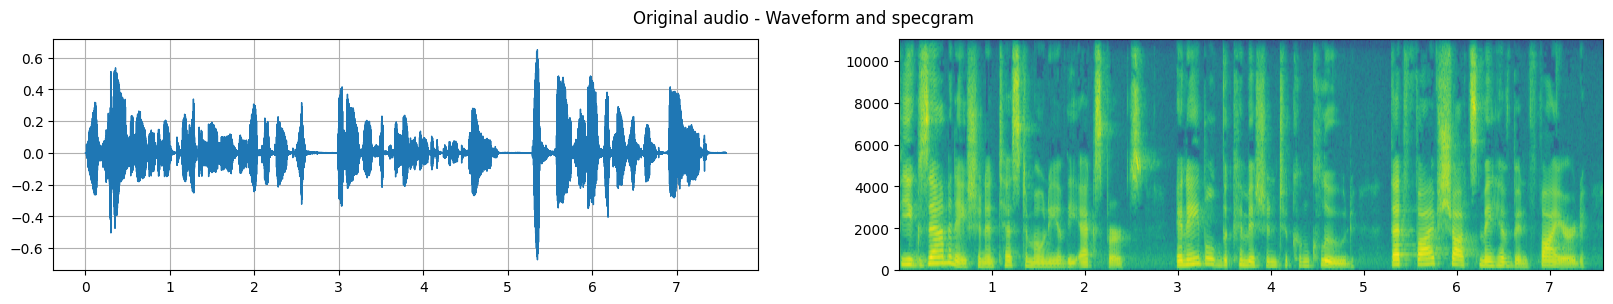

In [25]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from notebook import play_audio, plot_waveform_and_specgram

plot_waveform_and_specgram(audio, sr, title="Original audio")

In [26]:
play_audio(audio, sr)

## Generator

To watermark an audio, we simply load the watermarking generator from the hub:

In [27]:
from audioseal import AudioSeal

model = AudioSeal.load_generator("audioseal_wm_16bits")

# We add the batch dimension to the single audio to mimic the batch watermarking
audios = audio.unsqueeze(0)

watermark = model.get_watermark(audios, sample_rate=sr)
print(audios[:10], watermark[:10])
watermarked_audio = audios + watermark

# Alternatively, you can also call forward() function directly with different tune-down / tune-up rate
watermarked_audio = model(audios, sample_rate=sr, alpha=1)

tensor([[[-4.5776e-04, -4.2725e-04, -1.8311e-04,  ...,  3.0518e-05,
          -9.1553e-05, -9.1553e-04]]]) tensor([[[-8.9231e-05,  2.8447e-04,  7.3099e-04,  ..., -1.5899e-04,
          -1.3025e-04, -1.1316e-04]]], grad_fn=<SliceBackward0>)


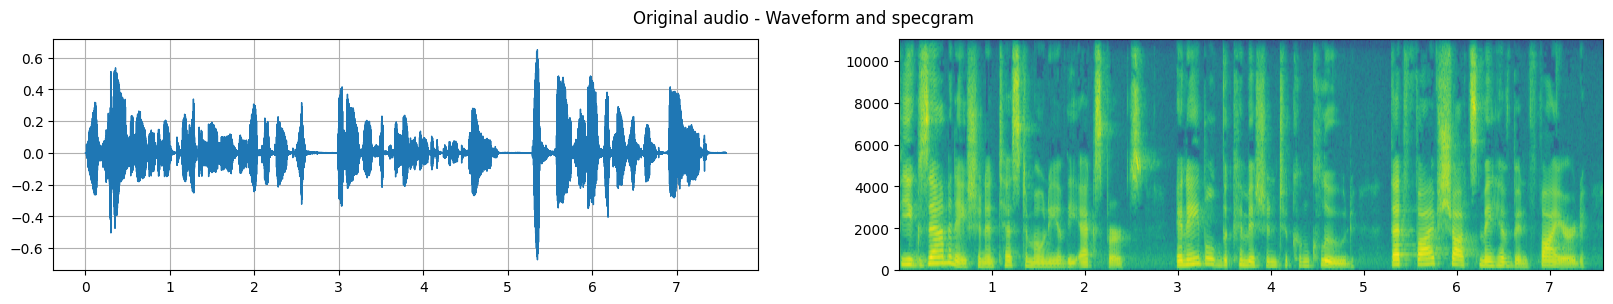

In [28]:
plot_waveform_and_specgram(audios.squeeze(), sr, title="Original audio")

In [29]:
play_audio(audio, sr)

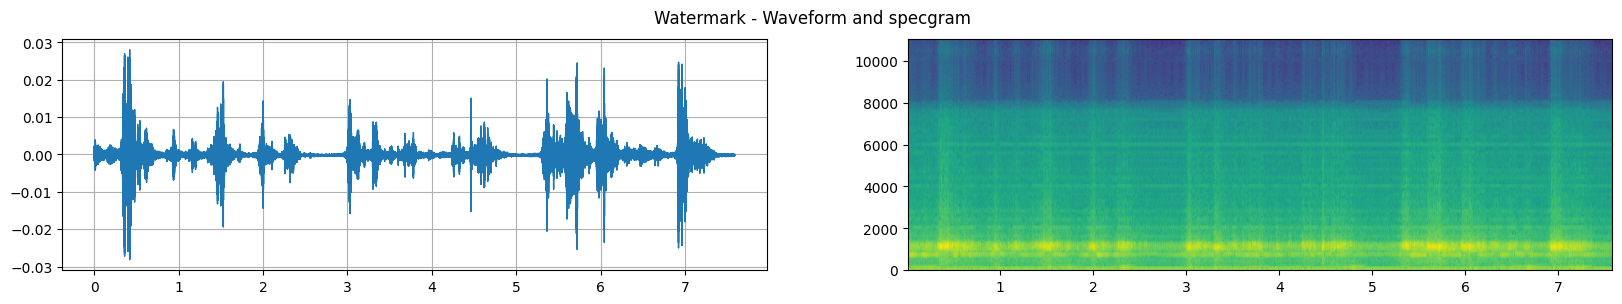

In [30]:
plot_waveform_and_specgram(watermark.squeeze(), sr, title="Watermark")

In [31]:
play_audio(watermark, sr)

We can see that the watermarked audio has preserved almost the same spectrogram and contents as the original one

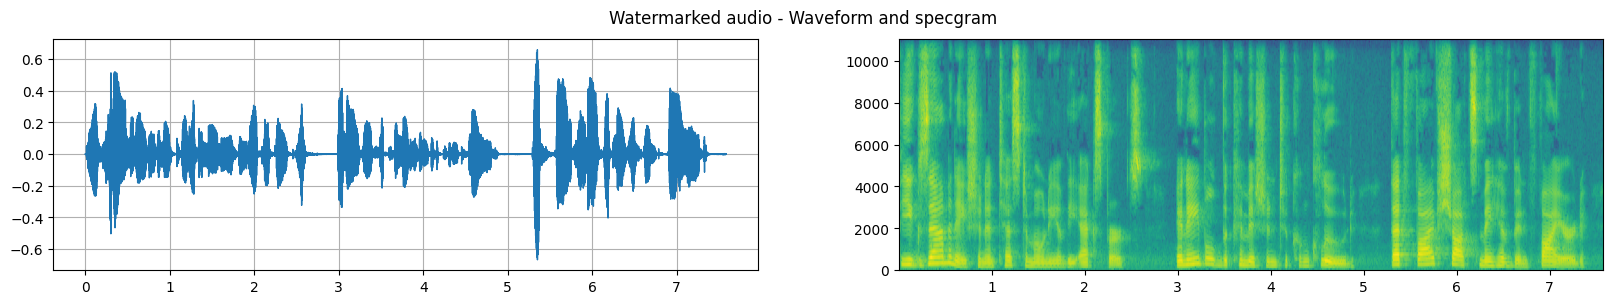

In [32]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Watermarked audio")

In [33]:
play_audio(watermarked_audio, sr)

### Watermarking with a secret message:

AudioSeal uses a secret message to generate a watermarking, which consists of <i>n</i> binary bits (n=16 for the above model, hence the model name). By default, if the user does not specify these n bits, a random message will be generated. This can be customized either by assigning the secret message before the watermarking process:

```
`model.message = <n bit Tensor>`
```

or by executing the model each time with one explicit secret message:

```
watermark = model(audio, message=<message>)
```

In [34]:
secret_mesage = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_mesage

tensor([[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]], dtype=torch.int32)

In [35]:
watermarked_audio = model(audios, sample_rate=sr, message=secret_mesage, alpha=1)

## Detector

To detect the watermarks from an audio, we load the separate detector model and can do one of the following:

### Basic usage: Call `detect_watermark()`
This results in a tuple of form `Tuple(float, Tensor)`, where the first value indicates the probability of the audio being watermarked (the higher, the more likely), and the second value is the decoded message that is embeded by the generator. If the audio is unwatermarked (low first value), the decoded message will be just some random bits.

Note that due to the stochastic nature of the detector, the decoded message and the secret message might miss by 1 bit, so depending on the user's need, the detection might be called multiple times to get an averaged decoded message.

In [36]:
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))

result, message = detector.detect_watermark(watermarked_audio, sample_rate=sr, message_threshold=0.5)

print(f"\nThis is likely a watermarked audio: {result}")

# Run on an unwatermarked audio
result2, message2 = detector.detect_watermark(audios, sample_rate=sr, message_threshold=0.5)
print(f"This is likely an unwatermarked audio: {result2}")



This is likely a watermarked audio: 1.0
This is likely an unwatermarked audio: 3.296440627309494e-05


In [37]:
message, message2

(tensor([[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]], dtype=torch.int32),
 tensor([[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]], dtype=torch.int32))

`message_threshold` indicates the threshold in which the detector will convert the stochastic messages (with probability between 0 and 1) into the n-bit binary format. In most of the case, the generator generates an unbiased message from the secret, so `0.5` is a reasonable choice (so in the above example, value > 0.5 means 1 and value < 0.5 means 0).


#### Advanced usage: Call `forward()`

The detector can also be called directly as a Torch module. This will return 2 tensors:
- The first tensor of size `batch x 2 x frames` indicates the probability of each frame being watermarked (positive or negative). So t[:, 0, :] corresponds to the negative probability and t[:, 1, :] corresponds to the positive probability
- The second tensor of size `batch x n_bits` corresponds to the message detected from the audio. It indicates the probability for each bit to be 1. In case of unwatermarked audios, this tensor is random

In [38]:
pred_prob, message_prob = detector(watermarked_audio, sample_rate=sr)
print(pred_prob[:, 1, :])

tensor([[0.9998, 0.9998, 0.9998,  ..., 0.9985, 0.9985, 0.9984]],
       grad_fn=<SliceBackward0>)


In [39]:
message_prob

tensor([[0.7822, 0.7472, 0.7853, 0.8301, 0.1863, 0.7036, 0.7709, 0.2262, 0.7633,
         0.2289, 0.2241, 0.7686, 0.8041, 0.1996, 0.8204, 0.2753]],
       grad_fn=<SigmoidBackward0>)

### Robustness against attacks

We can evaluate the robustness of the detector against some attacks. For this purpose, we will perform some simple attacks: Pink noise, highpass filter, compression in different formats. For the full list of attacks, please refer to our paper.


#### Pink noise attack

In [40]:
from attacks import AudioEffects as af

pink_noised_audio = af.pink_noise(watermarked_audio, noise_std=0.1)

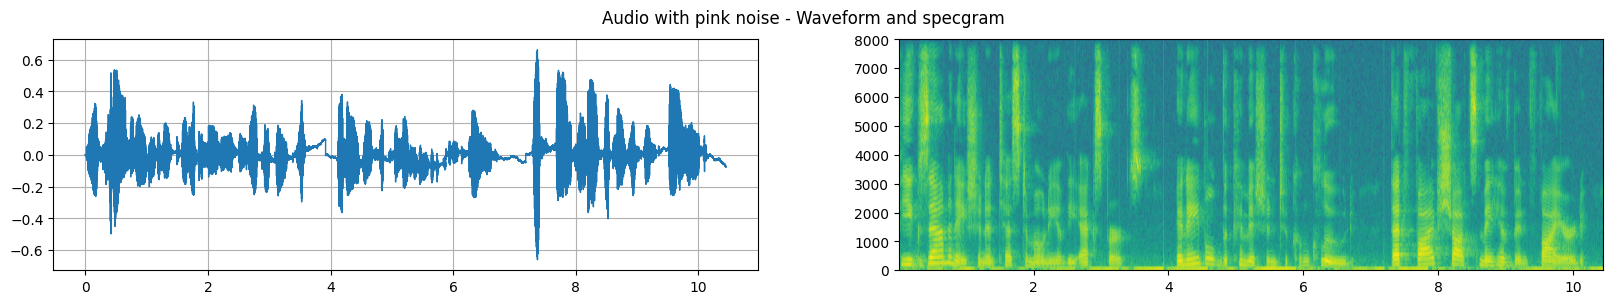

In [41]:
plot_waveform_and_specgram(pink_noised_audio, sample_rate=16000, title="Audio with pink noise")

In [42]:
play_audio(pink_noised_audio, sr)

In [43]:
result, message = detector.detect_watermark(pink_noised_audio, sample_rate=sr)
print(f"Detection Result with Pink Noise: {result}")

Detection Result with Pink Noise: 0.9950306415557861


#### Lowpass filter

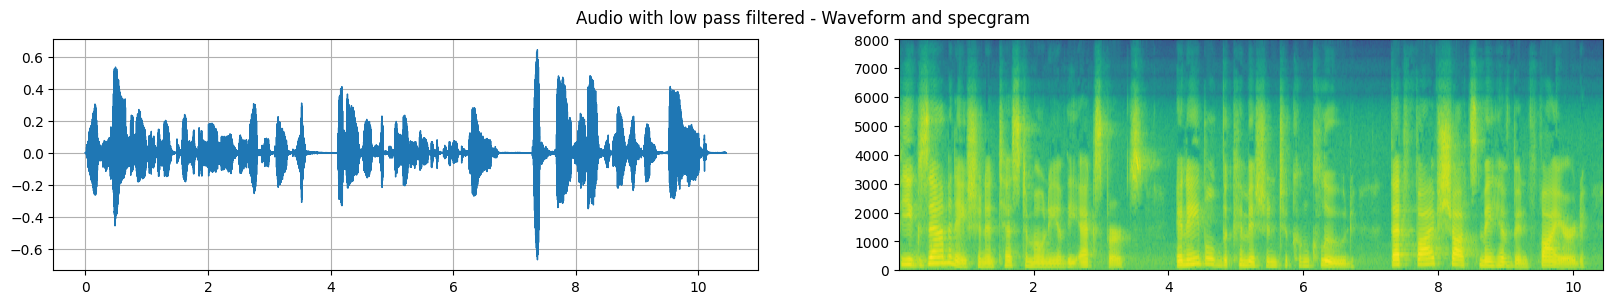

In [44]:
lowpass_filtered = af.lowpass_filter(watermarked_audio, cutoff_freq=5000, sample_rate=16000)
plot_waveform_and_specgram(lowpass_filtered, sample_rate=16000, title="Audio with low pass filtered")

In [45]:
play_audio(lowpass_filtered, sr)

In [46]:
result, message = detector.detect_watermark(lowpass_filtered, sample_rate=sr)
print(f"Detection Result with Lowpass Filter: {result}")

Detection Result with Lowpass Filter: 1.0


In [47]:
play_audio(torch.from_numpy(audio_numpy).unsqueeze(0).unsqueeze(0), sr)

In [48]:
result_gan, message_gan = detector.detect_watermark(torch.from_numpy(audio_numpy).unsqueeze(0).unsqueeze(0), sr)
print(f"Detection Result with Hifi-GAN: {result_gan}")
result_gan, message_ori = detector.detect_watermark(audio.unsqueeze(0), sr)
print(f"Detection Result with original audio: {result_gan}")


Detection Result with Hifi-GAN: 0.8322966694831848
Detection Result with original audio: 3.296440627309494e-05


In [49]:
message_gan, message_ori

(tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1]], dtype=torch.int32),
 tensor([[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]], dtype=torch.int32))

In [50]:
pred_gan, message_gan = detector(torch.from_numpy(audio_numpy).unsqueeze(0).unsqueeze(0), sample_rate=sr)
print(pred_gan[:, 1, :])

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       grad_fn=<SliceBackward0>)
